# Creating an animated GIF of construction permits over the years

by: Leanne Chan, 2020 
https://medium.com/@leannechannie/create-a-gif-with-3-million-points-using-dask-caf7dcd0667e

In [1]:
import dask.dataframe as dd
import numpy as np

In [2]:
# coords must be in 3857
permits = dd.read_csv('./data/DOB_Permit_Issuance.csv', 
                     dtype={
                         'Lot': 'int64',
                         'Block': 'int64',
                         "Owner's Phone # ": 'float64',
                         "Owner’s House Zip Code": 'float64',
                         "Permittee's License #": 'float64',
                         "Zip Code":'int64' 
                     },
                     usecols=['Filing Date', 'LATITUDE', 'LONGITUDE'])

In [3]:
permits['Filing Date'] = dd.to_datetime(permits['Filing Date'])

In [4]:
# conversion to web mercator (coords must be in 3857)
from datashader.utils import lnglat_to_meters
permits['x'], permits['y'] = lnglat_to_meters(permits['LONGITUDE'], permits['LATITUDE'])
permits = permits.drop(['LONGITUDE', 'LATITUDE'], axis=1)

In [5]:
# NYC limits
NYC        = (( -74.25,  -73.7), (40.50, 40.92)) #lng(east/west) and then lat(north/south)
x_range, y_range = [list(r) for r in lnglat_to_meters(NYC[0], NYC[1])]

# plot dimensions
plot_width  = int(750)
plot_height = int(plot_width//1.2)

In [6]:
# add NYC borough boundaries (coords must be in 3857)
import geopandas as gpd
NYCBoroughs= gpd.read_file("./data/borough boundaries")
NYCBoroughs = NYCBoroughs.to_crs({'init': 'epsg:3857'})

/Users/leannechannie/opt/anaconda3/envs/musa-620/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/leannechannie/opt/anaconda3/envs/musa-620/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [7]:
# plotting functions
from colorcet import fire
from matplotlib import pyplot as plt
import datashader as ds
import datashader.transfer_functions as tf
import imageio

In [8]:
def create_image(df, x_range, y_range, w=plot_width, h=plot_height, cmap=fire):
    
    # create the canvas
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    
    # plot dropoff positions, coutning number of passengers
    agg = cvs.points(df, 'x', 'y')
    
    # shade
    img = tf.shade(agg, cmap=cmap, how='eq_hist')
    
    # return an PIL image
    return tf.set_background(img, "black").to_pil()

In [9]:
def plot_permits_by_year(fig, all_data, year, city_limits, x_range, y_range):
    """
    Plot the permits by particular year
    """
    # trim to the specific year
    df_this_year = all_data.loc[all_data["Filing Date"].dt.strftime("%Y") == year]

    # create the datashaded image
    img = create_image(df_this_year, x_range, y_range)

    # plot the image on a matplotlib axes
    plt.clf()
    ax = fig.gca()
    ax.imshow(img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]])
    ax.set_axis_off()
    
    # plot the city limits
    city_limits.plot(ax=ax, facecolor="none", edgecolor="white")

    # add a text label for the hour
    ax.text(
        0.0,
        0.9,
        "Yearly Construction Permits\nFiled in NYC",
        color="white",
        fontsize=20,
        ha="left",
        transform=ax.transAxes,
    )

    ax.text(
        0.7,
        0.1,
        year,
        color="white",
        fontsize=40,
        ha="left",
        transform=ax.transAxes,
    )
    # draw the figure and return the image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

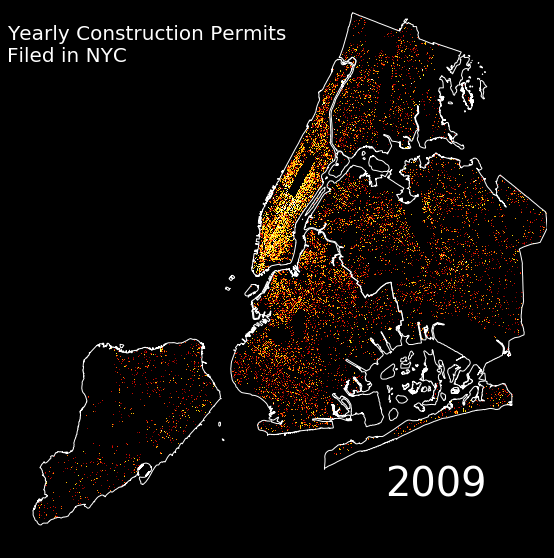

In [10]:
# Test on one year
fig, ax = plt.subplots(figsize=(10,10), facecolor='black')
imgs = []
img = plot_permits_by_year(fig, permits, '2009', NYCBoroughs, x_range=x_range, y_range=y_range)
imgs.append(img)
imageio.mimsave('permits.gif', imgs, fps=1)

processing 2009 ...
processing 2010 ...
processing 2011 ...
processing 2012 ...
processing 2013 ...
processing 2014 ...
processing 2015 ...
processing 2016 ...
processing 2017 ...
processing 2018 ...
processing 2019 ...


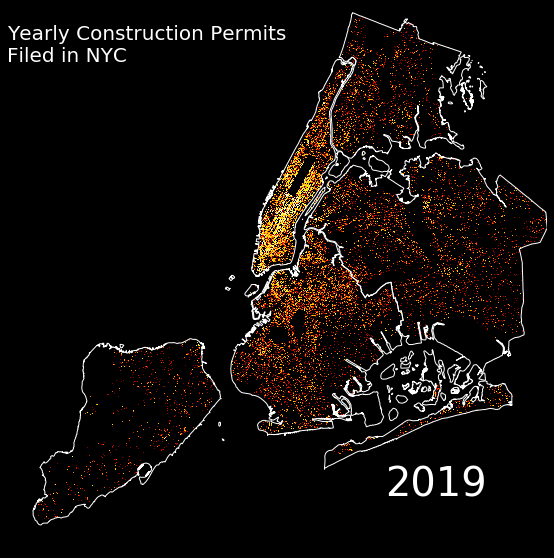

In [248]:
# create a figure
fig, ax = plt.subplots(figsize=(10,10), facecolor='black')

# Create an image for each hour
imgs = []
for year in ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017','2018', '2019']:
    print('processing ' + year + ' ...')
    img = plot_permits_by_year(fig, permits, year, NYCBoroughs, x_range=x_range, y_range=y_range)
    imgs.append(img)
    
    
# Combing the images for each hour into a single GIF
imageio.mimsave('permits.gif', imgs, fps=1)

processing 1999 ...
processing 2000 ...
processing 2001 ...
processing 2002 ...
processing 2003 ...
processing 2004 ...
processing 2005 ...
processing 2006 ...
processing 2007 ...
processing 2008 ...


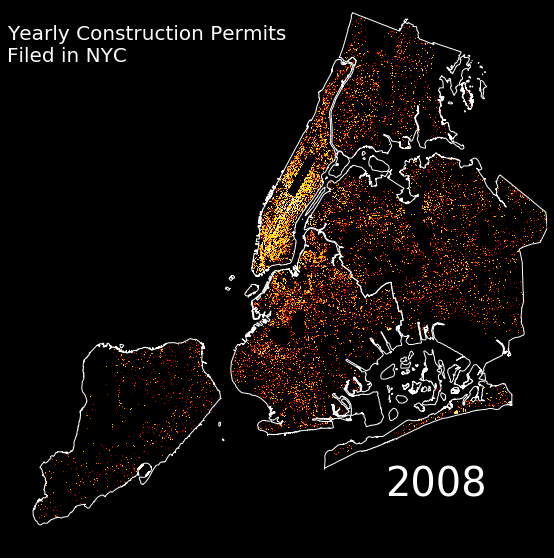

In [250]:
# try 1999 to 2008 
fig, ax = plt.subplots(figsize=(10,10), facecolor='black')

# Create an image for each hour
imgs2 = []
for year in ['1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007','2008']:
    print('processing ' + year + ' ...')
    img = plot_permits_by_year(fig, permits, year, NYCBoroughs, x_range=x_range, y_range=y_range)
    imgs2.append(img)
    
    
# Combing the images for each hour into a single GIF
imageio.mimsave('permits.gif', imgs2, fps=1)

In [251]:
img99_19 = imgs2 + imgs

In [252]:
imageio.mimsave('permits_99_19.gif', img99_19, fps=1)

processing 1989 ...
processing 1990 ...
processing 1991 ...
processing 1992 ...
processing 1993 ...
processing 1994 ...
processing 1995 ...
processing 1996 ...
processing 1997 ...
processing 1998 ...


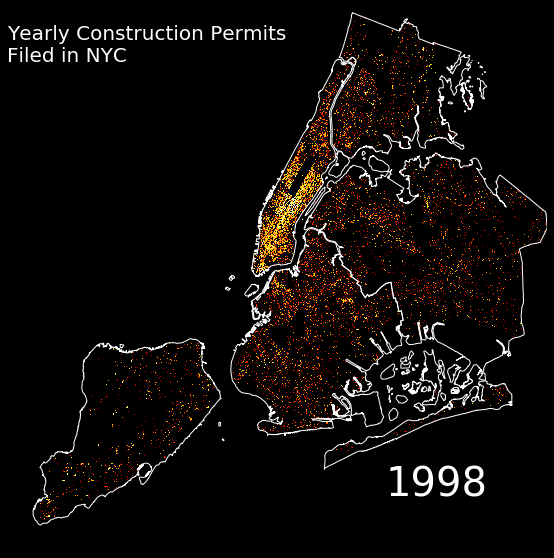

In [253]:
# try 1989 to 1998 
fig, ax = plt.subplots(figsize=(10,10), facecolor='black')

# Create an image for each hour
imgs3 = []
for year in ['1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997','1998']:
    print('processing ' + year + ' ...')
    img = plot_permits_by_year(fig, permits, year, NYCBoroughs, x_range=x_range, y_range=y_range)
    imgs3.append(img)
    
    
# Combing the images for each hour into a single GIF
imageio.mimsave('permits_89_98.gif', imgs3, fps=1)

In [254]:
img89_19 = imgs3 + imgs2 + imgs

In [255]:
imageio.mimsave('permits_89_19.gif', img89_19, fps=1)